# Part of Lab-Sheet 9 (COM3502-4502-6502 Speech Processing)

##  Fundamental Frequency Estimation based on Autocorrelation Analysis

<br>
<a id='Info'></a>
<div style="border: 2px solid #999; padding: 10px; background: #eee;">
    
**General Information**
    
<ul>
<li> 
    This Notebooks repeats knowledge from <a href="./../Lab-Sheet-7.ipynb">Lab-Sheet 7</a>, with minor implementation differences, i.e. the code is written function-based to be used by the <a href="./lpc.ipynb">LPC Notebook</a>.
</li>     
</ul>
</div>

This lab sheet is part of the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield").

It is probably easiest to open this Jupyter Notebook with [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true "Open in Google Colab") since GitHub's Viewer does not always show all details correctly. <a href="https://colab.research.google.com/github/sap-shef/SpeechProcesssingLab/blob/main/Lab-Sheets/LPC/fundamental_frequency.ipynb"><img align="right" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Notebook in Google Colab" title="Open and Execute the Notebook directly in Google Colaboratory"></a>

Please put questions, comments and correction suggestions in the [Blackboard](https://vle.shef.ac.uk) discussion board or send an email to [s.goetze@sheffield.ac.uk](mailto:s.goetze@sheffield.ac.uk).

## Navigation
![Fundamental Frequency needs Autocorrelation and is needed for LPC](images/flow_fundamental_frequency.svg)

This Lab Sheet contains several Notebooks (the blue-ish colour in the picture above indicates **this** Notebook to help with navigation):

* The Notebooks [`correlation.ipynb`](./correlation.ipynb),  [`autocorrelation.ipynb`](./autocorrelation.ipynb) and [`fundamental_frequency.ipynb`](./fundamental_frequency.ipynb)  repeat knowlege already known from lab sheet [Lab-Sheet 3](Lab-Sheet-3.ipynb) and [Lab-Sheet 7](Lab-Sheet-7.ipynb), respectively.
* The Notebook [`lpc_analysis.ipynb`](./lpc_analysis.ipynb)
* The Notebook [`lpc_synthesis.ipynb`](./lpc_synthesis.ipynb)
* The Notebook [`lpc.ipynb`](./lpc.ipynb) is the main Notebook relying an all other Notebooks and the code therein.

## Intended Learning Outcomes (ILOs)

After completing this notebook, students should be able to

- *argue* how autocorrelation is used to extract the fundamental frequency of a signal and
- *implement* a function to extract the fundamental frequency of a signal.

## Theory

With the knowledge from the [autocorrelation notebook](./autocorrelation.ipynb "Open Jupyter Notebook on Autocorrelation") we will now extract the fundamental frequency of a speech signal.
To do that we first calculate the autocorrelation estimate $\hat{r}_{xx}[k]$ of the signal and then look for the highest correlation value.
We only look in the time shifted range which corresponds to sensible frequencies (limited by $f_{min}$ and $f_{max}$):

For a given sample rate $f_s$ the period $n$ in samples relates to a given frequency $f$ by $n = \operatorname{round}\left(\frac{f_s}{f}\right).$
So for our maximal frequency $f_{max}$ we obtain the minimal time-shift $n_{min} = \operatorname{round}\left(\frac{f_s}{f_{max}}\right)$ and similarly the maximal time-shift $n_{max} = \operatorname{round}\left(\frac{f_s}{f_{min}}\right)$. Between those two values we find the time-shift $n_0$ of the maximal value which gives us the corresponding frequency $f_0 = \frac{f_s}{n_0}$.

The relation is also shown in the following figure where we see some autocorrelation sequence and observe how $f_{min}$ and $f_{max}$ constrain the search space for the highest autocorrelation value.

![](images/autocorrelation_frequencies.svg)

### Estimation of voiced/unvoiced speech

Lastly, for further processing, we want to know whether the correlation estimation was "good", "bad" or in between (where 0=good, 1=bad). If the correlation is below `correlation_min` or above `correlation_max` the correlation is deemed to be bad or good, respectively. For values in between we simply interpolate.
This value is called `noise_excitation_percentage` as the idea is that a high correlation value means that the signal consists mainly of impulses and hence the percentage of noise in the signal is low.
On the other hand, if the correlation is bad this means that lots of noise inhibited good correlation and hence the signal only contains little impulse (if at all). This then allows us to distinguish between voiced and unvoiced signals during the LPC analysis.

## Implementation

In [1]:
# We need the usual imports
import numpy as np
import matplotlib.pyplot as plt

import nb_importer
from autocorrelation import autocorrelation_function

%matplotlib inline

In [2]:
def fundamental_frequency(
    signal,
    sr,
    f_min_hz=80,
    f_max_hz=250,
    correlation_min=0.18,
    correlation_max=0.25,
):
    """Extract the fundamental frequency (in the given range) from the signal."""

    # First we autocorrelate the signal
    autocorrelation = autocorrelation_function(signal)

    # Normalize the amplitude of the autocorrelation function s.t. we know that the values are all in the interval $[-1, 1]$.
    autocorrelation /= np.max(np.abs(autocorrelation))

    # The minimal and maximal shift (in samples) we want to look at is calculated from the frequency boundaries
    n_min = round(sr / f_max_hz)
    n_max = round(sr / f_min_hz)

    # Find the position where the autocorrelation value is highest in the restricted range
    max_correlation_n = n_min + np.argmax(autocorrelation[n_min : n_max + 1])

    # Find the correlation value
    correlation_value = autocorrelation[max_correlation_n]
    # If correlation value is too small we will only want noise excitation, if it's large enough only pulse excitation,
    # if its in between we determine the percentage of noise excitation
    if correlation_value < correlation_min:
        noise_excitation_percentage = 1
    elif correlation_value > correlation_max:
        noise_excitation_percentage = 0
    else:
        noise_excitation_percentage = 1 - (
            (correlation_value - correlation_min) / (correlation_max - correlation_min)
        )

    # Find fundamental frequency from time shift and the noise excitation percentage
    return round(sr / max_correlation_n), noise_excitation_percentage

## Visualisation of Fundamantal Frequency Analysis

The following code shows the result of extracting the fundamental frequency.

In [3]:
def plot_fundamental_frequency(signal, sr, title, f_min_hz=80, f_max_hz=250):
    frequency, noise_percentage = fundamental_frequency(signal, sr, f_min_hz, f_max_hz)
    
    fig, ax = plt.subplots(figsize=(12, 4))
    fig.suptitle(f"{title} - estimated frequency: {frequency} Hz, noise percentage: {noise_percentage:.2f}")
    
    # 
    for i in range(len(signal) * frequency // sr + 1):
        if i % 2 == 0:
            ax.axvspan(i * sr // frequency, (i+1) * sr // frequency, alpha=0.1)
        ax.axvline(i * sr // frequency, color="C1")

    ax.plot(np.arange(len(signal)), signal, marker="o", lw=0.2)

    ax.set_ylabel("Amplitude")
    ax.set_xlabel("Time (samples)")
    ax.set_xlim(0, len(signal) - 1)
    
    fig.tight_layout()


## Examples

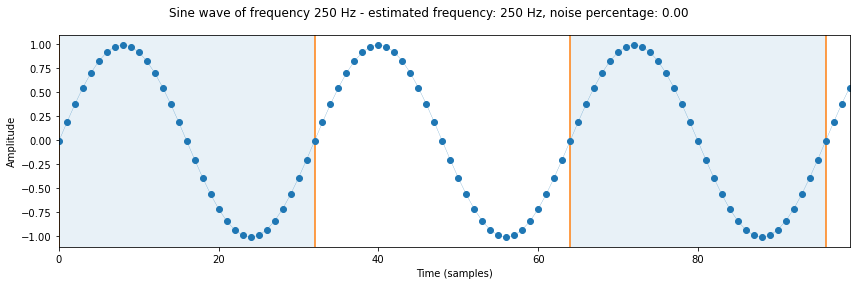

In [4]:
if __name__ == "__main__":
    sr = 8000
    num_samples = 100
    f = 250
    t = np.arange(num_samples) / sr  # time vector in seconds
    signal = np.sin(2 * np.pi * f * t)
    # Ensure zero-mean
    signal -= np.mean(signal)
    plot_fundamental_frequency(signal, sr, "Sine wave of frequency " + str(f) + " Hz", f_max_hz=500)

We plot the original signal in blue and indicate the extracted frequency by the orange bars and alternating shaded regions. We can see that we successfully extracted the input frequency of 250 Hz and also estimated that the signal is not noise-like.

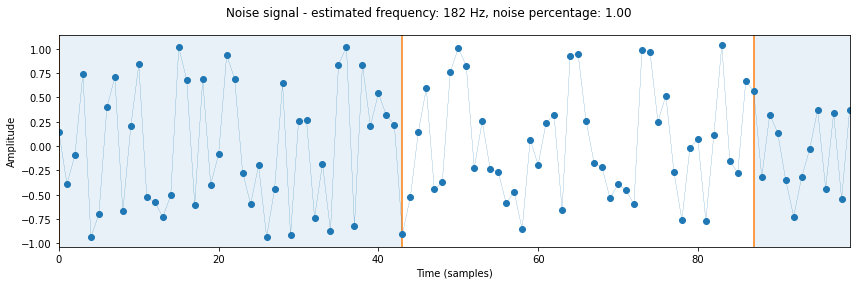

In [5]:
if __name__ == "__main__":
    np.random.seed(100)
    noise = np.random.uniform(-1, 1, size=num_samples)
    # Ensure zero-mean
    noise -= np.mean(noise)
    plot_fundamental_frequency(noise, sr, "Noise signal", f_max_hz=500)

When analyzing white noise we extract some fundamental frequency but as is indicated in the title, the correlation values are so small that the noise percentage is deemed to be 100 percent, i.e. the extracted fundamental frequency should be ignored.

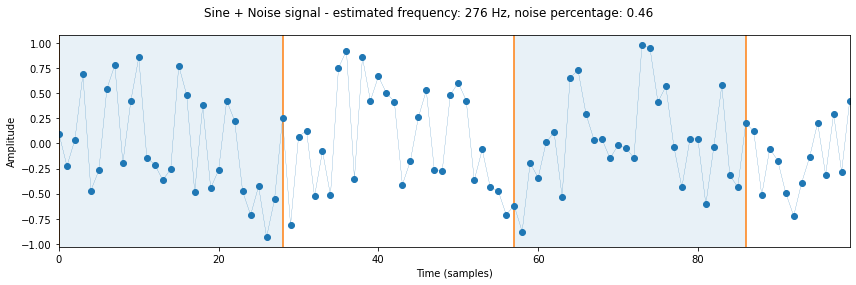

In [6]:
if __name__ == "__main__":
    np.random.seed(100)
    # Normalize to be between -1 and 1
    signal_plus_noise = (signal + 2.5 * np.random.uniform(-1, 1, size=num_samples)) / 3.5
    # Ensure zero-mean
    signal_plus_noise -= np.mean(signal_plus_noise)
    plot_fundamental_frequency(signal_plus_noise, sr, "Sine + Noise signal", f_max_hz=500)

When mixing a sine wave with noise, depending on the noise, we are either able to extract a relatively good approximation of the actual frequency or the noise is too strong as indicated by the noise percentage.
In this (fixed) example we can extract a fundamental frequency of 276 Hz which is close to the original 250 Hz one but we still observe that the noise percentage should be relatively high with 46%.